In [1]:
import os
import re
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from mne.io import read_raw_edf
from neurodsp.sim import sim_oscillation, sim_powerlaw, sim_knee
from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig

from timescales.sim import sim_lorentzian
from timescales.fit import PSD

# Overview

This notebook trains a linear model to predict aperiodic parameters using low power. Every 20th spectra is used to train a linear model to predict aperiodic parameters given log power. The linear model is 1430x faster than specparam, but slightly less accurate (mean r-squared 0.906 vs specparams's 0.914). This means that for 95% of spectra in the dataset, a single matrix vector product is required to predict each spectral parameter. This method can be used to accelerate sliding window spectral parameterization or used to provide accurate parameter guesses prior to optimization.

## Load Data

Skip to next section for analysis and results.

This data is human intracranial sleep/wake.

In [2]:
# Load region and channel info
rpath = '/Users/ryanhammonds/projects/data/sleep2/Information/RegionInformation.csv'
regions = pd.read_csv(rpath)

cpath = '/Users/ryanhammonds/projects/data/sleep2/Information/ChannelInformation.csv'
ch_info = pd.read_csv(cpath)

# Remove single quotes from channel names
ch_info['Channel name'] = [i[1:-1] for i in ch_info['Channel name']]

# Get row inds and channel names
rinds = [(i, j) for i, j in ch_info['Region'].items()]
inds = [i[0] for i in rinds]
rinds = [i[1] for i in rinds]

select = [i[1:-1] for i in ch_info.iloc[inds]['Channel name']]
select.sort()

# List of file names
files = os.listdir('/Users/ryanhammonds/projects/data/sleep2/data')
files_noext  = [i[:-5] for i in files]

# Sort
inds = np.argsort(files_noext)
files_noext = np.array(files_noext)[inds]
files = np.array(files)[inds]

# Filter for Dixi intracerebral electrodes (largest sample size)
files_filt = []
regions_inds = []

for i, f in enumerate(files_noext):
    
    if f[1] == 'D':
        ind = (ch_info['Channel name'] == f).values
        regions_inds.append(ch_info[ind]['Region'].values[0])
        files_filt.append(files[i])
        
regions_inds = np.array(regions_inds)

# Convert list of file strings to one concat string
file_str = ''
for f in files:
    file_str += f
    
ch_files = {
    'wake':{'files':[], 'coords':[]},
    'nrem2':{'files':[], 'coords':[]},
    'nrem3':{'files':[], 'coords':[]},
    'rem':{'files':[], 'coords':[]}
}

trial_lookup = {'W': 'wake', 'N': 'nrem2', 'D': 'nrem3', 'R': 'rem'}

regions = []

inds = []

for i, ch in enumerate(ch_info['Channel name'].values):
    m = re.search(ch + '.\.edf', file_str)
    
    if m is not None:
        
        fstr = m.group()
        trial = fstr[-5]
        
        if trial == 'R':
            # skip rem sleep
            continue
            
        key = trial_lookup[trial]
            
        ch_files[key]['files'].append(fstr)

        ch_files[key]['coords'].append(
            (ch_info.iloc[i].x, ch_info.iloc[i].y, ch_info.iloc[i].z)
        )
        
        regions.append(ch_info.iloc[i].Region)
        
        inds.append(i)

In [3]:
base_path = '/Users/ryanhammonds/projects/data/sleep2/data/'

fs = 200

wake_files = ch_files['wake']['files']
nrem_files = [*ch_files['nrem2']['files'], *ch_files['nrem3']['files']]

n_wake_files = len(wake_files)
n_nrem_files = len(nrem_files)

wake_taus = np.zeros(n_wake_files)
wake_rsq = np.zeros(n_wake_files)

nrem_taus = np.zeros(n_nrem_files)
nrem_rsq = np.zeros(n_nrem_files)

sigs_wake = []
for i, f in tqdm(enumerate(wake_files), total=len(wake_files)):
    
    edf = read_raw_edf(base_path + f, verbose=False)
    
    sig = edf.get_data()[0]
    sig = normalize_sig(sig, 0, 1)
    sigs_wake.append(sig)

  0%|          | 0/312 [00:00<?, ?it/s]

## Modeling

Train a linear model to predict spectral parameters. Every 20th spectra is used to train a linear model to predict aperiodic parameters.

In [4]:
from statsmodels.regression.linear_model import burg
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

def fit(X, y_train, inds_train, inds_test):
    
    X_train = X[inds_train]
    X_test = X[inds_test]
    
    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    
    lr = LinearRegression(n_jobs=-1)
    lr.fit(X_train, y_train)
    
    return lr

In [5]:
# 4 second epochs
sigs = np.array(sigs_wake).reshape(-1, 800) 

# Drop windows with low variance (e.g. constant values at edges)
sigs = sigs[np.var(sigs, axis=1) > .01]

# PSD
freqs, powers = compute_spectrum(np.array(sigs), fs)

In [6]:
X = np.log10(powers)

inds = np.arange(len(X))
inds_train = inds[::20]
inds_test = np.array([i for i in inds if i not in inds_train])

In [7]:
# Get target params for training
psd = PSD()
psd.fit(freqs, powers[inds_train], progress="tqdm.notebook")

Fitting PSD:   0%|                                                                                            …

In [8]:
# Fit linear models to predict aperiodic parameters: offset, knee, exp, constant
lr0 = fit(X, psd.params[:, 0], inds_train, inds_test)
lr1 = fit(X, psd.params[:, 1], inds_train, inds_test)
lr2 = fit(X, psd.params[:, 2], inds_train, inds_test)
lr3 = fit(X, psd.params[:, 3], inds_train, inds_test)

In [9]:
# Get aperiodic parameters via linear models
X = np.log10(powers)

X_test = X[inds_test]
X_test = StandardScaler().fit_transform(X_test)

def predict_params(X, lr0, lr1, lr2, lr3):
    phat = np.vstack((
        lr0.predict(X),
        lr1.predict(X),
        lr2.predict(X),
        lr3.predict(X)
    )).T
    return phat

phat = predict_params(X_test, lr0, lr1, lr2, lr3)

# Enforce positive bounds for knee and constant params
phat[:, 1][phat[:, 1] < 0] = 1e-8
phat[:, 3][phat[:, 3] < 0] = 1e-8

In [10]:
# Get PSDs of linearly predicted params
powers_test_pred = np.array([sim_lorentzian(freqs, *p[[1, 2, 0, 3]]) for p in phat])

# Get specparam's params (e.g. "true" values)
powers_test = powers[inds_test]
psd_train = PSD()
psd_train.fit(freqs, powers_test, method='fooof', fooof_init={'max_n_peaks':0}, n_jobs=-1)

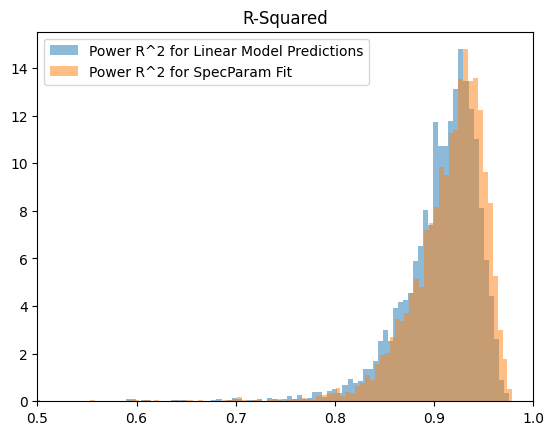

In [11]:
rsq_lin = np.array([np.corrcoef(i, j)[0][1]**2
                    for i, j in zip(np.log10(powers_test_pred[:, 1:]), np.log10(powers_test[:, 1:]))])
plt.hist(rsq_lin, bins=100, alpha=.5, density=True, label='Power R^2 for Linear Model Predictions')

rsq_sp = np.array([np.corrcoef(i, j)[0][1]**2 
                   for i, j in zip(np.log10(psd_train.powers_fit), np.log10(powers_test[:, 1:]))])
plt.hist(rsq_sp, bins=100, alpha=.5, density=True, label='Power R^2 for SpecParam Fit');

plt.title('R-Squared')
plt.xlim(0.5, 1.)
plt.legend();

In [12]:
s = time.time()
psd_train = PSD()
psd_train.fit(freqs, powers_test, method='fooof', fooof_init={'max_n_peaks':0})
e = time.time()
sp_run = (e-s)*1000
print('SpecParam Runtime: ', sp_run, ' ms')
print('SpecParam R^2: ', rsq_sp.mean(), ' ms')

SpecParam Runtime:  21076.208114624023  ms
SpecParam R^2:  0.9142825584514275  ms


In [15]:
s = time.time()
predict_params(X_test, lr0, lr1, lr2, lr3)
e = time.time()
lr_run = (e-s)*1000
print('LinReg Runtime: ', lr_run, ' ms')
print('LinReg R^2: ', rsq_lin.mean(), ' ms')

LinReg Runtime:  14.734983444213867  ms
LinReg R^2:  0.9063069545269192  ms


In [16]:
print(f'Linear Regression is {sp_run/lr_run} times faster')

Linear Regression is 1430.3516657767423 times faster
